In [1]:
import pandas as pd
import warnings
import joblib
import pydotplus
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from skompiler import skompile
import graphviz

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

In [2]:
df = pd.read_csv("./dataset/hitters.csv")

In [3]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [4]:
for col in df.columns:
    if df[col].isnull().any():
        count = df[col].isnull().sum()
        print({col, count})

{'Salary', 59}


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AtBat,322.0,380.928571,153.404981,16.0,255.25,379.5,512.00,687.0
Hits,322.0,101.024845,46.454741,1.0,64.00,96.0,137.00,238.0
HmRun,322.0,10.770186,8.709037,0.0,4.00,8.0,16.00,40.0
Runs,322.0,50.909938,26.024095,0.0,30.25,48.0,69.00,130.0
RBI,322.0,48.027950,26.166895,0.0,28.00,44.0,64.75,121.0
Walks,322.0,38.742236,21.639327,0.0,22.00,35.0,53.00,105.0
Years,322.0,7.444099,4.926087,1.0,4.00,6.0,11.00,24.0
CAtBat,322.0,2648.683230,2324.205870,19.0,816.75,1928.0,3924.25,14053.0
CHits,322.0,717.571429,654.472627,4.0,209.00,508.0,1059.25,4256.0
CHmRun,322.0,69.490683,86.266061,0.0,14.00,37.5,90.00,548.0


In [7]:
df["Salary"].value_counts().sum()

263

In [8]:
def grab_col_names(data_frame, cat_th=10 , car_th=20): 
    cat_cols = [col for col in data_frame.columns if data_frame[col].dtype == "O"]
    num_but_cat = [col for col in data_frame.columns if data_frame[col].nunique() < car_th and data_frame[col].dtype != "O"]
    cat_but_car = [col for col in data_frame.columns if data_frame[col].nunique() > car_th and data_frame[col].dtype == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in data_frame.columns if data_frame[col].dtype != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {data_frame.shape[0]}")
    print(f"Variables: {data_frame.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"num_but_car: {len(num_but_cat)}")
    return num_cols,cat_cols,cat_but_car

In [94]:
def outliers_treshold(data_frame, col_name, q1=0.05 ,q3=0.95):
    quartile1 = data_frame[col_name].quantile(q1)
    quartile3 = data_frame[col_name].quantile(q3)
    interquartile_range = quartile3-quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return up_limit, low_limit


In [95]:
def grab_outliers(data_frame,col_name,index=False):
    up,low = outliers_treshold(data_frame,col_name)
    if data_frame[((data_frame[col_name] < low) | (data_frame[col_name] > up))].shape[0] > 10:
        print(data_frame[((data_frame[col_name] < low) | (data_frame[col_name] > up))].head())
    else:
        print(data_frame[((data_frame[col_name] < low) | (data_frame[col_name] > up))])
    if index:
        outlier_index = data_frame[((data_frame[col_name] < low) | (data_frame[col_name] > up))].index
        return outlier_index

In [96]:
def check_outliers(data_frame, col_name):
    up_limit,low_limit = outliers_treshold(data_frame,col_name)
    if data_frame[(data_frame[col_name] > up_limit) | (data_frame[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [97]:
num_cols,cat_cols,cat_but_cat = grab_col_names(df)

Observations: 322
Variables: 20
cat_cols: 3
cat_but_car: 0
num_cols: 17
num_but_car: 0


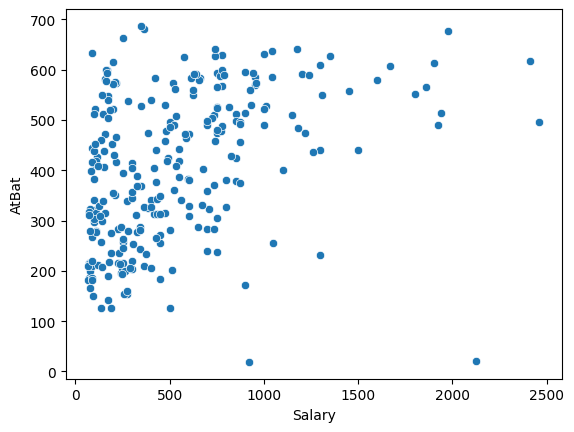

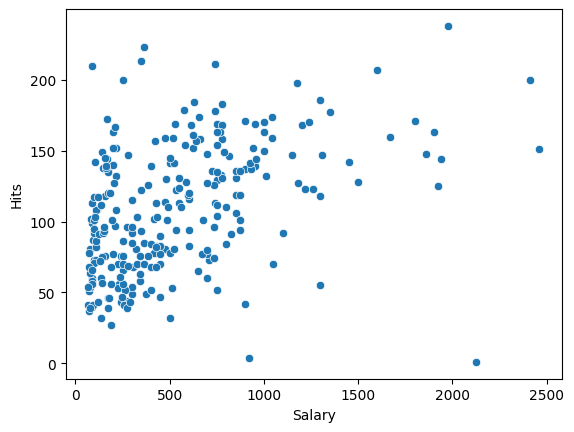

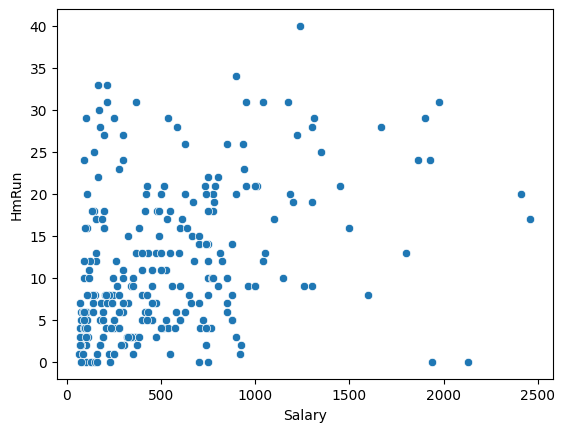

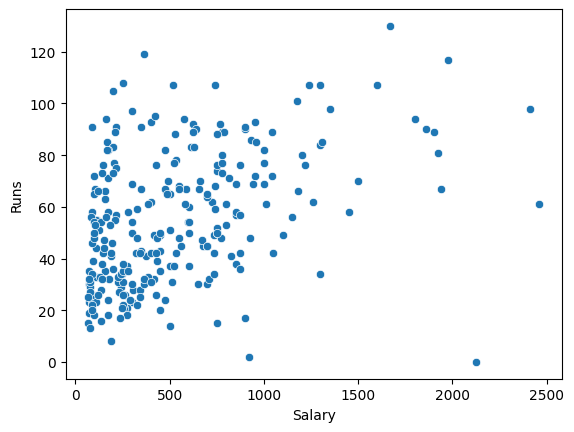

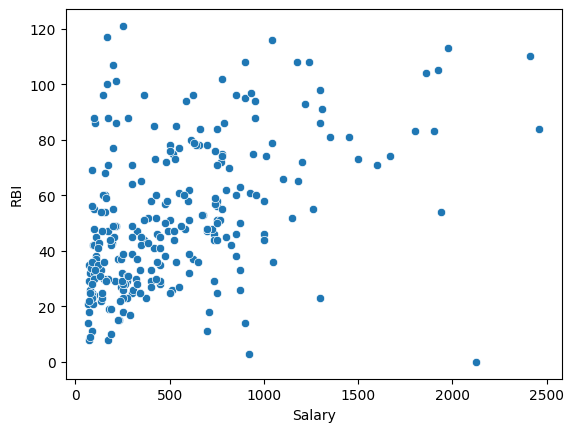

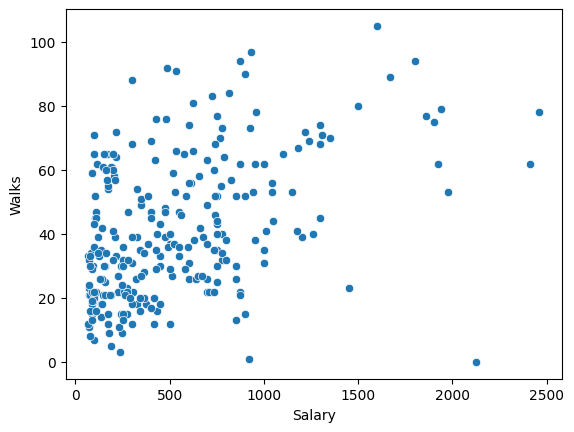

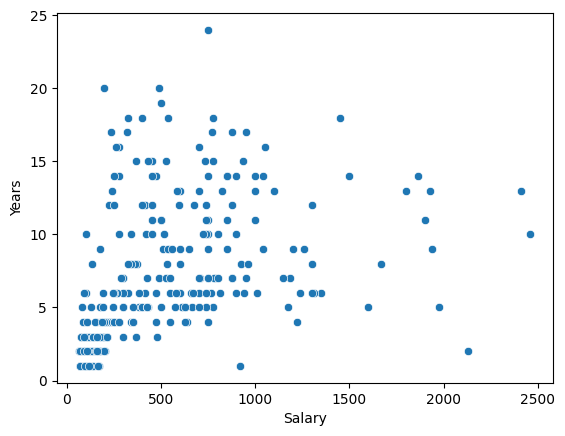

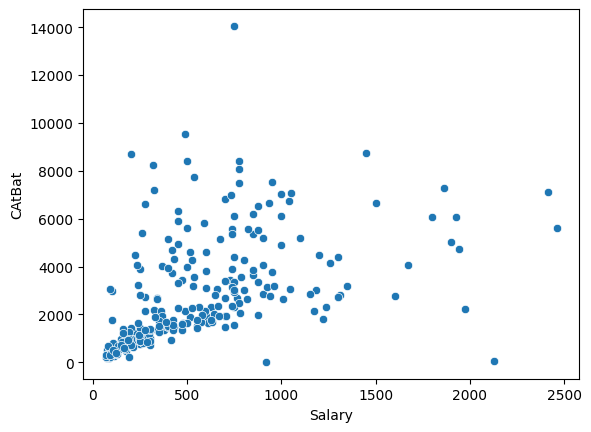

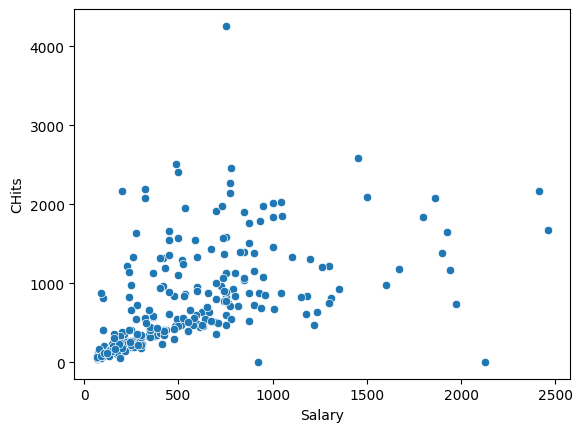

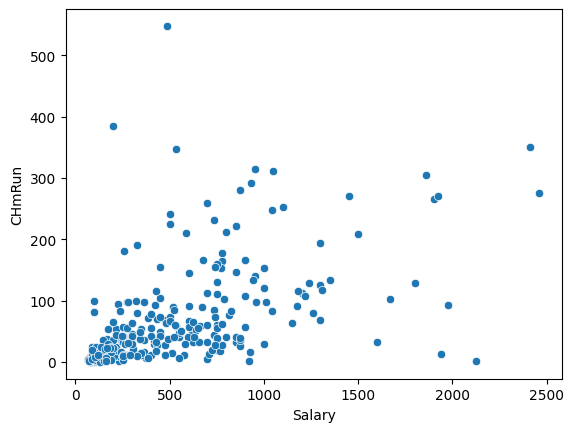

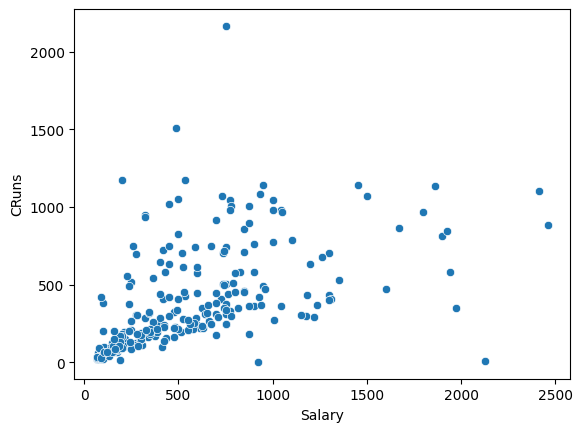

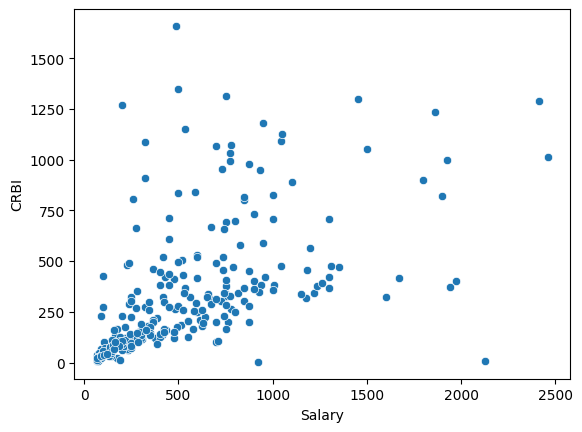

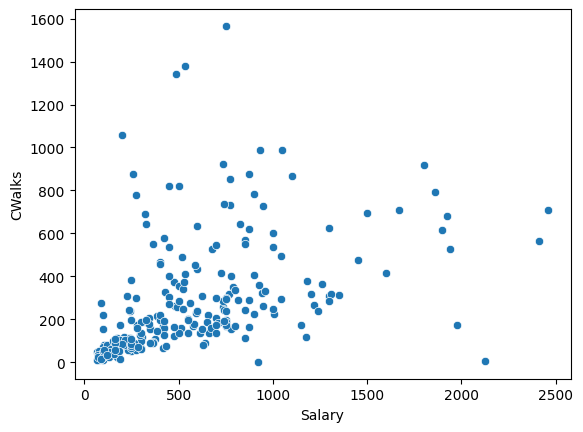

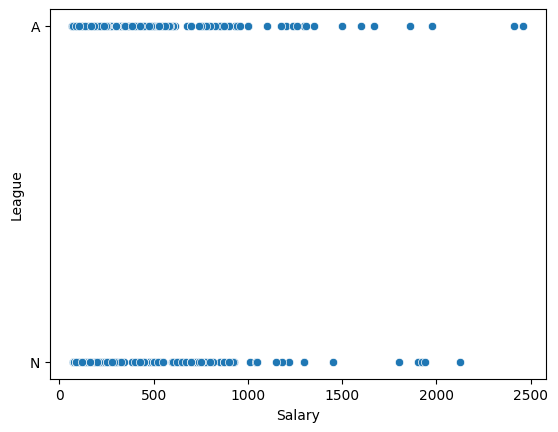

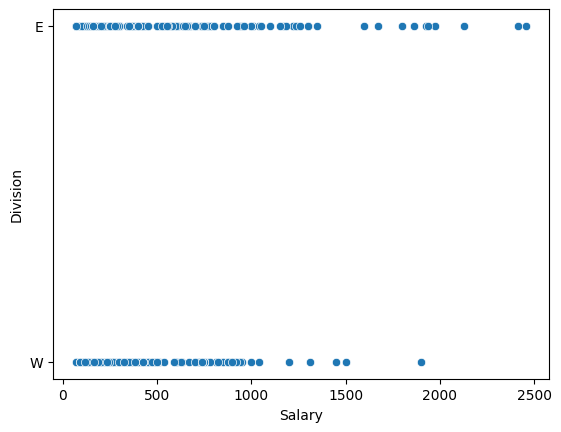

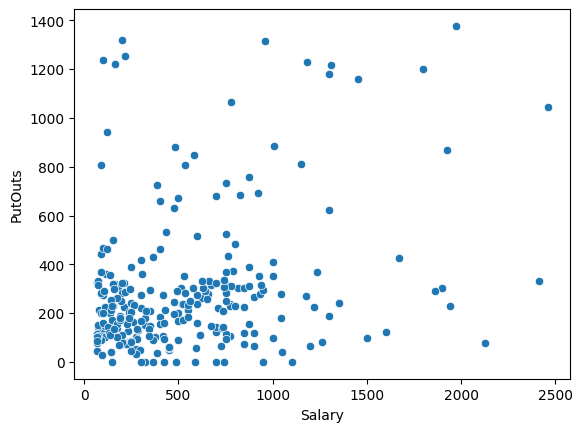

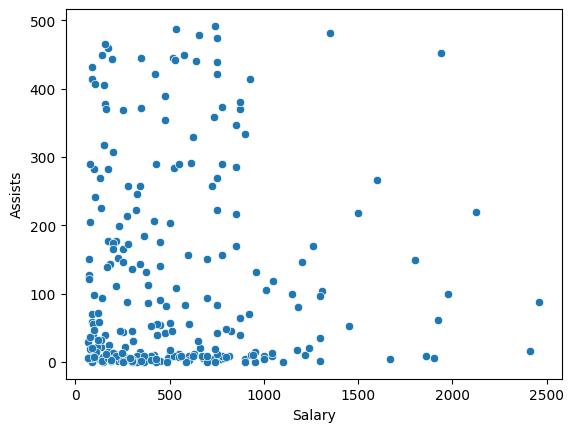

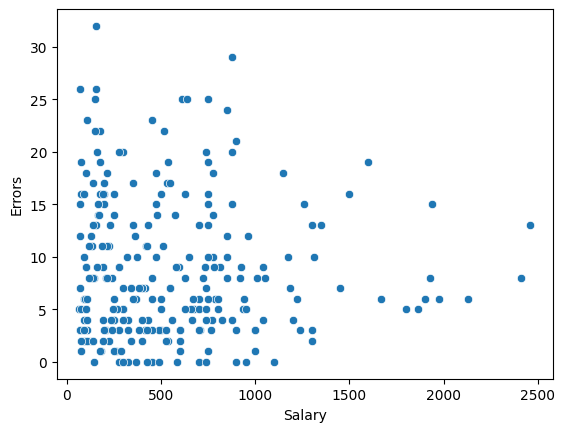

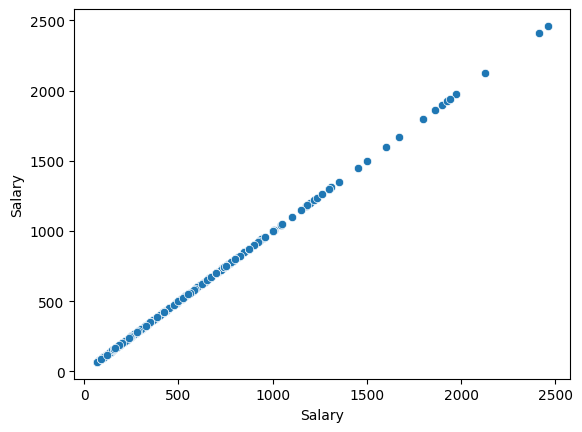

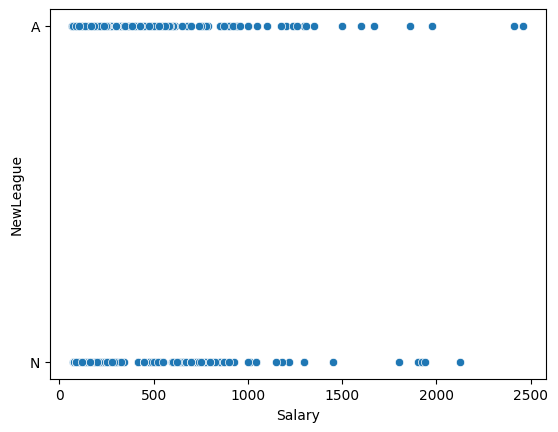

In [98]:
for col in df.columns:
    sns.scatterplot(x='Salary', y=col, data=df)
    plt.show(block=True)

In [99]:
for col in num_cols: 
    if check_outliers(df,col):
        outlier_index = grab_outliers(df,col,True)
        c = outlier_index[0].sum()
        print({col: c, "count" : df[col].value_counts().sum()},end="\n\n\n")
    

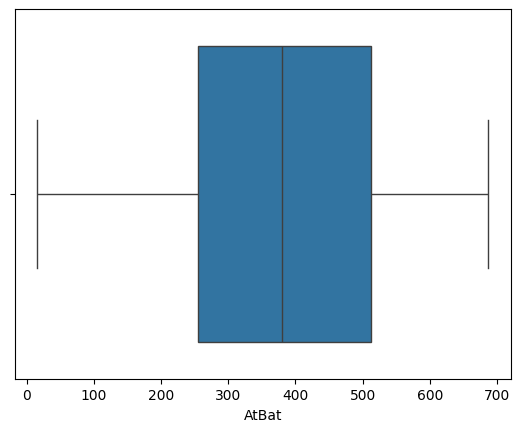

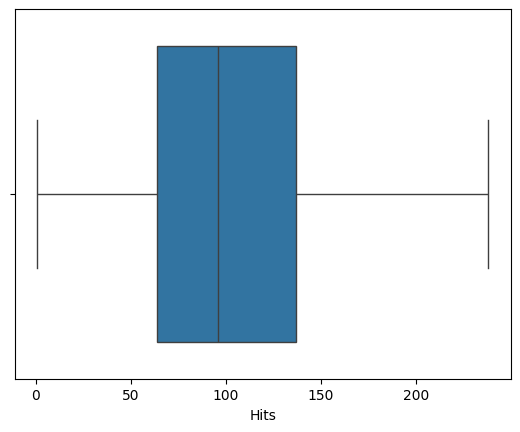

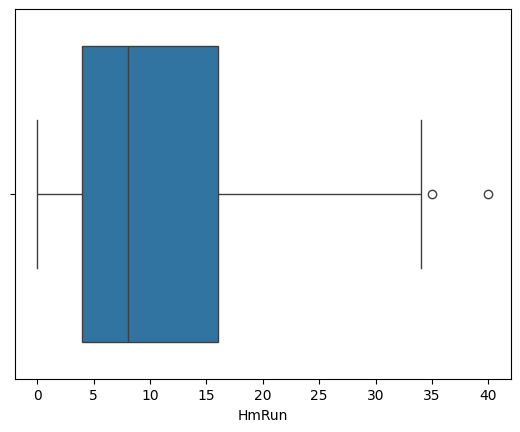

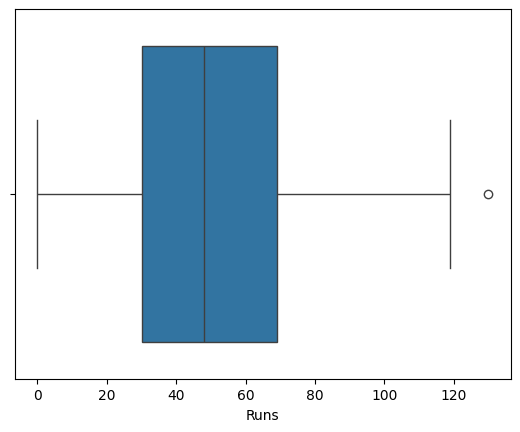

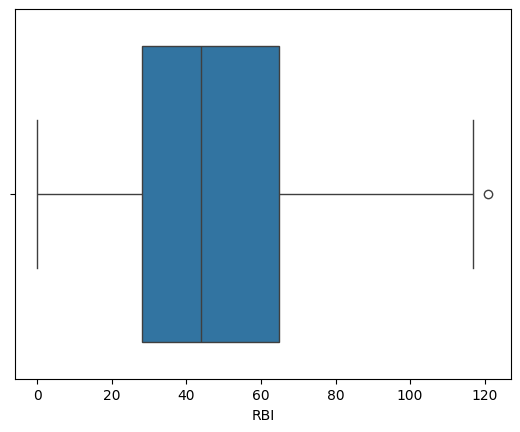

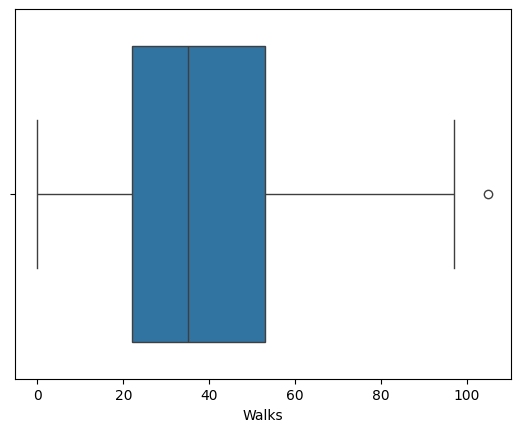

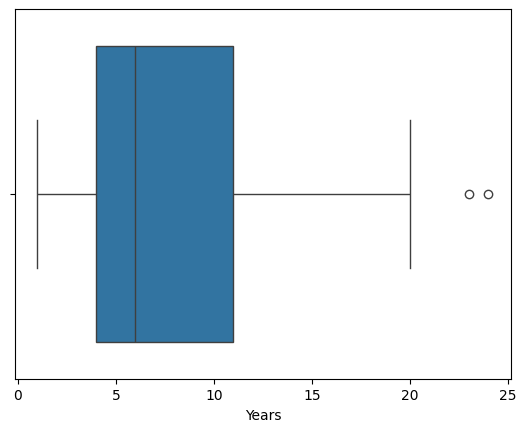

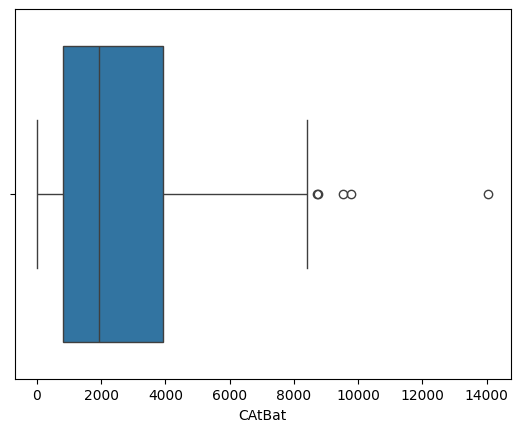

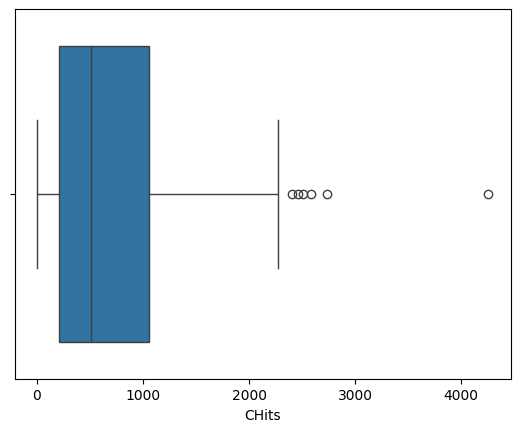

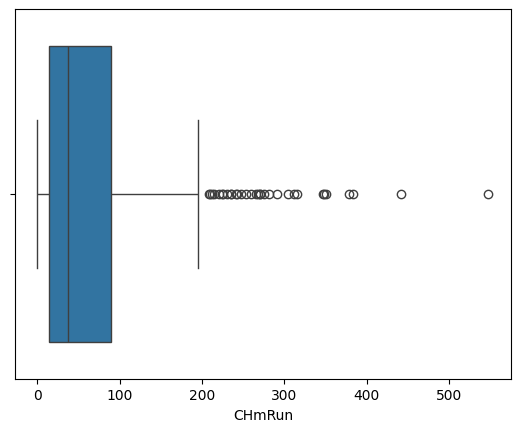

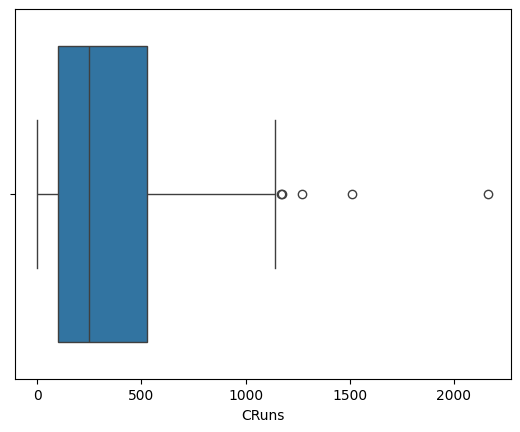

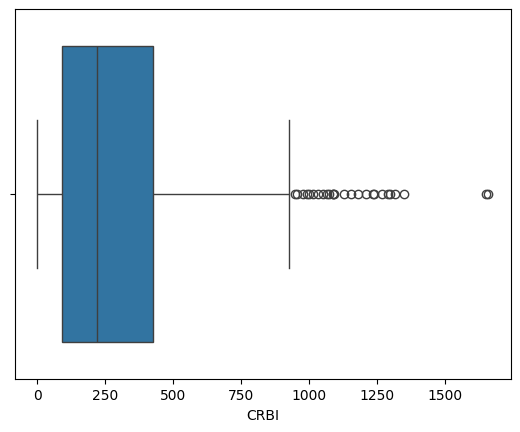

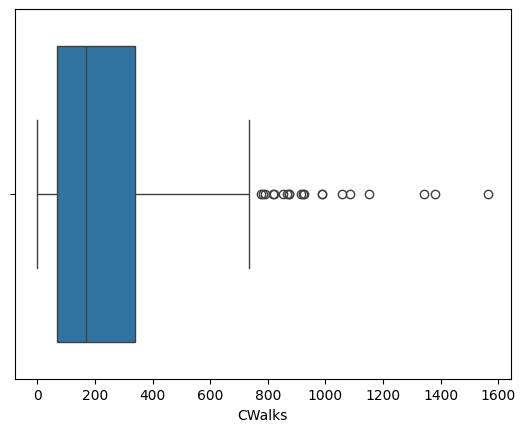

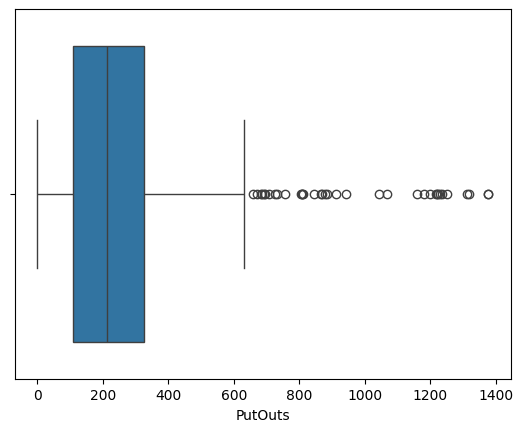

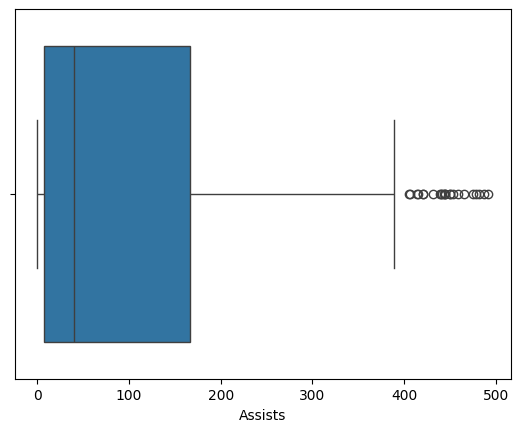

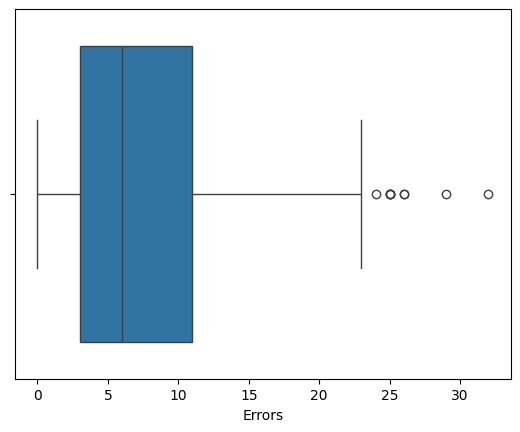

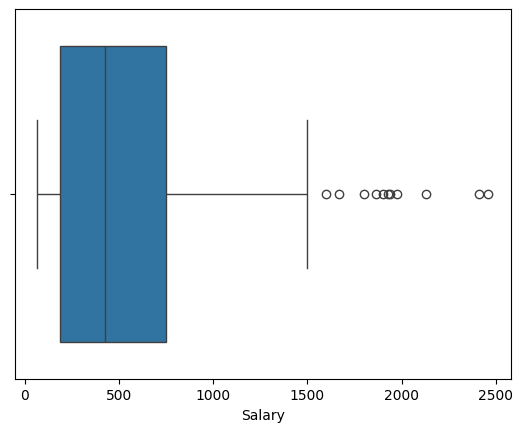

In [79]:
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.show()

In [100]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

In [107]:
# Apply imputer to the 'salary' column only
df['Salary'] = imputer.fit_transform(df[['Salary']])


In [110]:
for col in cat_cols:
    cat_count = df[col].unique()
    print({col : cat_count})

{'League': array(['A', 'N'], dtype=object)}
{'Division': array(['E', 'W'], dtype=object)}
{'NewLeague': array(['A', 'N'], dtype=object)}


In [116]:
has_league_changed = df["League"] != df["NewLeague"]
print(has_league_changed)

0      False
1      False
2      False
3      False
4      False
       ...  
317    False
318    False
319    False
320    False
321    False
Length: 322, dtype: bool


In [130]:
df["HAS_LEAGUE_CHANGED"] = has_league_changed

In [119]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,RobustScaler

In [120]:
def label_encoder(data_frame,binary_col):
    labelencoder = LabelEncoder()
    data_frame[binary_col] = labelencoder.fit_transform(data_frame[binary_col])

    return data_frame

In [124]:
binary_cols = cat_cols + ["HAS_LEAGUE_CHANGED"]

In [132]:
for col in binary_cols:
   df = label_encoder(df,col)

In [133]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,HAS_LEAGUE_CHANGED
0,293,66,1,30,29,14,1,293,66,1,30,29,14,0,0,446,33,20,535.925882,0,0
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.000000,1,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.000000,0,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.000000,1,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.500000,1,0


In [141]:
new_salaries = pd.qcut(df["Salary"], q = 4, labels=["starter","mid-gamer","highmid-gamer","superstar"])
new_salaries.value_counts()

Salary
mid-gamer        136
starter           81
superstar         78
highmid-gamer     27
Name: count, dtype: int64

In [142]:
df["CAT_SALARIES"] = new_salaries

In [147]:
new_experience = pd.qcut(df["Years"], q=4, labels=["newbie","intermediate","experienced","veteran"])
new_experience.value_counts()

Years
newbie          112
experienced      76
veteran          74
intermediate     60
Name: count, dtype: int64

In [148]:
df["CAT_EXPERIENCES"] = new_experience

In [150]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,HAS_LEAGUE_CHANGED,CAT_SALARIES,CAT_EXPERIENCES
0,293,66,1,30,29,14,1,293,66,1,30,29,14,0,0,446,33,20,535.925882,0,0,mid-gamer,newbie
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.000000,1,0,mid-gamer,veteran
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.000000,0,0,mid-gamer,newbie
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.000000,1,0,mid-gamer,experienced
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.500000,1,0,starter,newbie


In [157]:
df.groupby("CAT_EXPERIENCES").agg({"Salary":["mean","count"]})

Salary      
                       mean count
CAT_EXPERIENCES                  
newbie           286.742879   112
intermediate     591.514805    60
experienced      703.378584    76
veteran          696.017176    74

In [158]:
df.groupby("League").agg({"Salary":["mean","count"]})

Salary      
              mean count
League                  
0       540.750107   175
1       530.182757   147

In [159]:
df.groupby("Division").agg({"Salary":["mean","count"]})

Salary      
                mean count
Division                  
0         608.515482   157
1         466.855778   165

In [175]:
new_division_experience = df["Division"].astype(str) + "_" + df["CAT_EXPERIENCES"].astype(str)
new_division_experience.value_counts()

1_newbie          60
0_newbie          52
1_veteran         39
0_experienced     39
1_experienced     37
0_veteran         35
0_intermediate    31
1_intermediate    29
Name: count, dtype: int64

In [176]:
df["NEW_DIVISION_EXPERIENCE"] = new_division_experience

In [177]:
df.groupby("NEW_DIVISION_EXPERIENCE").agg({"Salary":"mean"})

,Salary
NEW_DIVISION_EXPERIENCE,
0_experienced,775.603366
0_intermediate,684.890666
0_newbie,322.660951
0_veteran,779.383408
1_experienced,627.249758
1_intermediate,491.699229
1_newbie,255.613882
1_veteran,621.201326


In [180]:
new_league_cat = df["League"].astype(str) + "L--" + df["NEW_DIVISION_EXPERIENCE"]
new_league_cat.value_counts()

0L--1_newbie          35
1L--0_newbie          33
1L--1_newbie          25
0L--0_veteran         25
1L--1_experienced     22
0L--0_intermediate    21
0L--1_veteran         21
0L--0_experienced     20
0L--0_newbie          19
1L--0_experienced     19
0L--1_intermediate    19
1L--1_veteran         18
0L--1_experienced     15
1L--0_veteran         10
1L--1_intermediate    10
1L--0_intermediate    10
Name: count, dtype: int64

In [181]:
df["NEW_LEAGUE_DIVISION_EXP"] = new_league_cat

In [184]:
df.groupby("NEW_LEAGUE_DIVISION_EXP").agg({"Salary":"mean"}).sort_values(by="Salary", ascending=False)

,Salary
NEW_LEAGUE_DIVISION_EXP,
1L--0_veteran,890.982988
0L--0_experienced,805.079382
1L--0_experienced,744.575981
0L--0_veteran,734.743576
0L--0_intermediate,721.203697
0L--1_experienced,633.419761
0L--1_veteran,630.308627
1L--1_experienced,623.042938
1L--1_veteran,610.576140


In [199]:
league_times_division = df["League"].astype(str) + df["Division"].astype(str)
league_times_division.value_counts()

01    90
00    85
11    75
10    72
Name: count, dtype: int64

In [200]:
df["LEAGUE_TIMES_DIVISION"] = league_times_division

In [202]:
df.groupby("LEAGUE_TIMES_DIVISION").agg({"Salary":"mean"})

,Salary
LEAGUE_TIMES_DIVISION,
00,643.864823
01,443.363986
10,566.783621
11,495.045928


In [201]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,HAS_LEAGUE_CHANGED,CAT_SALARIES,CAT_EXPERIENCES,NEW_DIVISION_EXPERIENCE,NEW_LEAGUE_DIVISION_EXP,LEAGUE_TIMES_DIVISION
0,293,66,1,30,29,14,1,293,66,1,30,29,14,0,0,446,33,20,535.925882,0,0,mid-gamer,newbie,0_newbie,0L--0_newbie,00
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.000000,1,0,mid-gamer,veteran,1_veteran,1L--1_veteran,11
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.000000,0,0,mid-gamer,newbie,1_newbie,0L--1_newbie,01
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.000000,1,0,mid-gamer,experienced,0_experienced,1L--0_experienced,10
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.500000,1,0,starter,newbie,0_newbie,1L--0_newbie,10


In [203]:
def one_hot_encoder(data_frame, categorical_cols, drop_first=True):
    data_frame = pd.get_dummies(data_frame, columns=categorical_cols,drop_first=drop_first)
    return data_frame

In [213]:
ohe_cols = [col for col in df.columns if 16 >= df[col].nunique() > 2]
ohe_cols

['CAT_SALARIES',
 'CAT_EXPERIENCES',
 'NEW_DIVISION_EXPERIENCE',
 'NEW_LEAGUE_DIVISION_EXP',
 'LEAGUE_TIMES_DIVISION']

In [225]:
df = one_hot_encoder(df,ohe_cols)

In [218]:
binary_cols = [col for col in df.columns if df[col].nunique() == 2]
binary_cols

['League', 'Division', 'NewLeague', 'HAS_LEAGUE_CHANGED']

In [219]:
ss = StandardScaler()

In [221]:
num_cols,cat_cols,cat_but_car = grab_col_names(df)

Observations: 322
Variables: 26
cat_cols: 9
cat_but_car: 0
num_cols: 17
num_but_car: 6


In [226]:
df[num_cols] = ss.fit_transform(df[num_cols])

In [227]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,HAS_LEAGUE_CHANGED,CAT_SALARIES_mid-gamer,CAT_SALARIES_highmid-gamer,CAT_SALARIES_superstar,CAT_EXPERIENCES_intermediate,CAT_EXPERIENCES_experienced,CAT_EXPERIENCES_veteran,NEW_DIVISION_EXPERIENCE_0_intermediate,NEW_DIVISION_EXPERIENCE_0_newbie,NEW_DIVISION_EXPERIENCE_0_veteran,NEW_DIVISION_EXPERIENCE_1_experienced,NEW_DIVISION_EXPERIENCE_1_intermediate,NEW_DIVISION_EXPERIENCE_1_newbie,NEW_DIVISION_EXPERIENCE_1_veteran,NEW_LEAGUE_DIVISION_EXP_0L--0_intermediate,NEW_LEAGUE_DIVISION_EXP_0L--0_newbie,NEW_LEAGUE_DIVISION_EXP_0L--0_veteran,NEW_LEAGUE_DIVISION_EXP_0L--1_experienced,NEW_LEAGUE_DIVISION_EXP_0L--1_intermediate,NEW_LEAGUE_DIVISION_EXP_0L--1_newbie,NEW_LEAGUE_DIVISION_EXP_0L--1_veteran,NEW_LEAGUE_DIVISION_EXP_1L--0_experienced,NEW_LEAGUE_DIVISION_EXP_1L--0_intermediate,NEW_LEAGUE_DIVISION_EXP_1L--0_newbie,NEW_LEAGUE_DIVISION_EXP_1L--0_veteran,NEW_LEAGUE_DIVISION_EXP_1L--1_experienced,NEW_LEAGUE_DIVISION_EXP_1L--1_intermediate,NEW_LEAGUE_DIVISION_EXP_1L--1_newbie,NEW_LEAGUE_DIVISION_EXP_1L--1_veteran,LEAGUE_TIMES_DIVISION_01,LEAGUE_TIMES_DIVISION_10,LEAGUE_TIMES_DIVISION_11
0,-0.574071,-0.755130,-1.123591,-0.804734,-0.728308,-1.145172,-1.310194,-1.015121,-0.997117,-0.795183,-0.985636,-0.905069,-0.923478,0,0,0.560399,-0.540924,1.880899,-1.130910e-16,0,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,-0.430437,-0.431732,-0.433579,-1.035649,-0.383827,0.011930,1.332925,0.344876,0.179704,-0.005697,-0.113299,0.252124,0.430391,1,1,1.224048,-0.467740,0.308192,-1.497229e-01,1,0,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
2,0.640293,0.624699,0.831443,0.580752,0.917547,1.724442,-0.903560,-0.441561,-0.398759,-0.075357,-0.404078,-0.192719,0.010354,0,1,2.108915,-0.182323,0.937275,-1.374356e-01,0,0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
3,0.751283,0.861858,1.061447,0.542266,1.147201,-0.080638,0.722974,1.283860,1.312145,1.805477,1.406546,1.526538,0.351634,1,0,-0.317331,-0.701928,-0.792703,-8.828642e-02,1,0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
4,-0.391264,-0.302373,-0.088573,-0.458363,-0.230724,-0.404626,-1.106877,-0.970736,-0.943555,-0.667472,-0.931677,-0.853972,-0.852222,1,0,1.841314,-0.489695,-0.635432,-1.092159e+00,1,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False


In [312]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, cross_val_score

In [228]:
X = df.drop('Salary', axis=1)
y = df['Salary']

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [233]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [234]:
y_pred = model.predict(X_test)

In [235]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.4002107558927934


In [261]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error" , mae)

Mean Absolute Error 0.23128511811610547


In [262]:
rmse = np.sqrt(mse)  # Or directly use mean_squared_error with `squared=False`
print("Root Mean Squared Error", rmse)

Root Mean Squared Error 0.3088747748161328


In [265]:
r2 = r2_score(y_test, y_pred)
print("R2 score", r2)

R2 score 0.9160939764296244


In [273]:
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

In [274]:
print("Negative MSE scores:", scores)
print("Mean of scores:", scores.mean())
print("Standard deviation of scores:", scores.std())

Negative MSE scores: [-0.19013973 -0.39040006 -0.20849337 -0.4272256  -0.18003805]
Mean of scores: -0.2792593627105625
Standard deviation of scores: 0.10680942234977768


In [275]:
def rare_analyzer(data_frame,target,cat_cols):
    for col in cat_cols:
        print(col, ":" , len(data_frame[col].value_counts()))
        print(pd.DataFrame({"COUNT": data_frame[col].value_counts(),
                           "RATİO": 100 * data_frame[col].value_counts() / len(data_frame),
                           "TARGET_MEAN" : data_frame.groupby(col)[target].mean()}), end="\n\n\n")

In [276]:
num_cols,cat_cols,cat_but_car=grab_col_names(df)

Observations: 322
Variables: 52
cat_cols: 35
cat_but_car: 0
num_cols: 17
num_but_car: 35


In [277]:
rare_analyzer(df,"Salary",cat_cols)

League : 2
        COUNT      RATİO  TARGET_MEAN
League                               
0         175  54.347826     0.011855
1         147  45.652174    -0.014114


Division : 2
          COUNT      RATİO  TARGET_MEAN
Division                               
0           157  48.757764     0.178386
1           165  51.242236    -0.169737


NewLeague : 2
           COUNT      RATİO  TARGET_MEAN
NewLeague                               
0            176  54.658385     0.002337
1            146  45.341615    -0.002817


HAS_LEAGUE_CHANGED : 2
                    COUNT      RATİO  TARGET_MEAN
HAS_LEAGUE_CHANGED                               
0                     303  94.099379     0.002609
1                      19   5.900621    -0.041604


CAT_SALARIES_mid-gamer : 2
                        COUNT      RATİO  TARGET_MEAN
CAT_SALARIES_mid-gamer                               
False                     186  57.763975     0.166827
True                      136  42.236025    -0.228161


CAT_SALARI

In [282]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and 
               (df[col].value_counts() / len(df) < 0.04).any(axis=None)]
useless_cols

['NEW_LEAGUE_DIVISION_EXP_1L--0_intermediate',
 'NEW_LEAGUE_DIVISION_EXP_1L--0_veteran',
 'NEW_LEAGUE_DIVISION_EXP_1L--1_intermediate']

In [285]:
corr_matrix

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,HAS_LEAGUE_CHANGED,CAT_SALARIES_mid-gamer,CAT_SALARIES_highmid-gamer,CAT_SALARIES_superstar,CAT_EXPERIENCES_intermediate,CAT_EXPERIENCES_experienced,CAT_EXPERIENCES_veteran,NEW_DIVISION_EXPERIENCE_0_intermediate,NEW_DIVISION_EXPERIENCE_0_newbie,NEW_DIVISION_EXPERIENCE_0_veteran,NEW_DIVISION_EXPERIENCE_1_experienced,NEW_DIVISION_EXPERIENCE_1_intermediate,NEW_DIVISION_EXPERIENCE_1_newbie,NEW_DIVISION_EXPERIENCE_1_veteran,NEW_LEAGUE_DIVISION_EXP_0L--0_intermediate,NEW_LEAGUE_DIVISION_EXP_0L--0_newbie,NEW_LEAGUE_DIVISION_EXP_0L--0_veteran,NEW_LEAGUE_DIVISION_EXP_0L--1_experienced,NEW_LEAGUE_DIVISION_EXP_0L--1_intermediate,NEW_LEAGUE_DIVISION_EXP_0L--1_newbie,NEW_LEAGUE_DIVISION_EXP_0L--1_veteran,NEW_LEAGUE_DIVISION_EXP_1L--0_experienced,NEW_LEAGUE_DIVISION_EXP_1L--0_intermediate,NEW_LEAGUE_DIVISION_EXP_1L--0_newbie,NEW_LEAGUE_DIVISION_EXP_1L--0_veteran,NEW_LEAGUE_DIVISION_EXP_1L--1_experienced,NEW_LEAGUE_DIVISION_EXP_1L--1_intermediate,NEW_LEAGUE_DIVISION_EXP_1L--1_newbie,NEW_LEAGUE_DIVISION_EXP_1L--1_veteran,LEAGUE_TIMES_DIVISION_01,LEAGUE_TIMES_DIVISION_10,LEAGUE_TIMES_DIVISION_11
AtBat,1.000000,0.967939,0.592198,0.913060,0.820539,0.669845,0.047372,0.235526,0.252717,0.236659,0.266534,0.244053,0.166123,-0.101663,-0.045441,0.317550,0.353824,0.352117,0.342474,-0.057655,-0.085414,-0.360141,0.121724,0.408066,0.154775,0.066439,-0.024324,0.124503,-0.143056,0.011107,-0.021830,0.082236,-0.065753,-0.041962,0.086348,-0.077068,0.066811,0.026176,0.025587,-0.005439,-0.008171,0.056908,0.088799,-0.113695,-0.083139,-0.049459,0.100955,-0.089347,-0.050812,0.017460,-0.048218,-0.072272
Hits,0.967939,1.000000,0.562158,0.922187,0.811073,0.641211,0.044767,0.227565,0.255815,0.202712,0.261787,0.232005,0.151818,-0.101038,-0.071143,0.310673,0.320455,0.310038,0.384974,-0.060608,-0.083958,-0.348024,0.152755,0.416652,0.188552,0.073180,-0.031008,0.164170,-0.161264,0.026917,-0.022028,0.087307,-0.082452,-0.065664,0.135718,-0.076286,0.075907,0.035465,0.016347,-0.028582,-0.038920,0.069767,0.085978,-0.136396,-0.068801,-0.057468,0.121875,-0.086727,-0.051427,-0.016000,-0.052675,-0.067142
HmRun,0.592198,0.562158,1.000000,0.650988,0.855122,0.481014,0.116318,0.221882,0.220627,0.493227,0.262361,0.351979,0.233154,-0.177258,-0.017206,0.282923,-0.106329,0.039318,0.311615,-0.166044,-0.066134,-0.218182,0.041499,0.309207,0.083274,-0.044185,0.113760,0.024367,-0.102927,0.095287,-0.089029,0.088161,-0.060731,0.055787,0.027232,0.026322,0.095753,-0.043304,0.062698,-0.017162,0.118360,-0.044915,0.002673,-0.145335,0.023261,-0.076362,0.060321,-0.068405,-0.047982,0.065805,-0.120393,-0.090209
Runs,0.913060,0.922187,0.650988,1.000000,0.798206,0.732213,0.004541,0.186497,0.204830,0.227913,0.250556,0.205976,0.182168,-0.150392,-0.076311,0.279347,0.220567,0.240475,0.372257,-0.115446,-0.082317,-0.314510,0.118774,0.378290,0.184603,0.041332,-0.038164,0.148625,-0.138793,0.039226,-0.048972,0.097953,-0.057276,-0.086633,0.131130,-0.066086,0.064874,0.039331,0.042968,-0.017989,-0.019899,0.001375,0.066076,-0.117055,-0.029696,-0.094754,0.103282,-0.062416,-0.101649,0.017606,-0.069280,-0.108933
RBI,0.820539,0.811073,0.855122,0.798206,1.000000,0.615997,0.146168,0.294688,0.308201,0.441771,0.323285,0.393184,0.250914,-0.145597,-0.075531,0.343186,0.106591,0.193370,0.401647,-0.120124,-0.098637,-0.294516,0.114615,0.387544,0.135337,-0.000035,0.103391,0.104026,-0.146478,0.095865,-0.097669,0.076897,-0.108581,0.041865,0.065191,-0.031544,0.124065,-0.023362,0.042611,-0.040473,0.064229,0.037566,0.084094,-0.153217,-0.019378,-0.103941,0.069018,-0.110915,-0.009574,0.018670,-0.063338,-0.109140
Walks,0.669845,0.641211,0.481014,0.732213,0.615997,1.000000,0.136475,0.277175,0.280671,0.332473,0.338478,0.308631,0.424507,-0.045337,-0.059086,0.299515,0.149656,0.129382,0.402465,-0.020029,-0.032393,-0.259272,0.073621,0.383509,0.095782,0.060791,0.094323,0.046777,-0.156088,0.129315,-0.022294,0.082083,-0.11

In [286]:
columns_to_drop = df.filter(regex='^NEW_DIVISION_EXPERIENCE').columns
columns_to_drop

Index(['NEW_DIVISION_EXPERIENCE_0_intermediate', 'NEW_DIVISION_EXPERIENCE_0_newbie', 'NEW_DIVISION_EXPERIENCE_0_veteran', 'NEW_DIVISION_EXPERIENCE_1_experienced', 'NEW_DIVISION_EXPERIENCE_1_intermediate', 'NEW_DIVISION_EXPERIENCE_1_newbie', 'NEW_DIVISION_EXPERIENCE_1_veteran'], dtype='object')

In [288]:
df = df.drop(columns_to_drop,axis=1)

In [290]:
# Assuming 'df' is your DataFrame
corr_matrix = df.corr()

# Mask to hide the upper triangle and diagonal, as the matrix is symmetric
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Apply the mask to get correlations that are only in the upper triangle and greater than 0.6
high_corr = corr_matrix.where(mask) > 0.6

# Optional: Convert to a DataFrame to see the pairs more clearly
high_corr_pairs = high_corr.stack().reset_index()
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] == True]

print(high_corr_pairs)


                                Variable 1                Variable 2  Correlation
1                                    AtBat                      Hits         True
3                                    AtBat                      Runs         True
4                                    AtBat                       RBI         True
5                                    AtBat                     Walks         True
48                                    Hits                      Runs         True
49                                    Hits                       RBI         True
50                                    Hits                     Walks         True
93                                   HmRun                      Runs         True
94                                   HmRun                       RBI         True
139                                   Runs                       RBI         True
140                                   Runs                     Walks         True
185             

In [291]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,HAS_LEAGUE_CHANGED,CAT_SALARIES_mid-gamer,CAT_SALARIES_highmid-gamer,CAT_SALARIES_superstar,CAT_EXPERIENCES_intermediate,CAT_EXPERIENCES_experienced,CAT_EXPERIENCES_veteran,NEW_LEAGUE_DIVISION_EXP_0L--0_intermediate,NEW_LEAGUE_DIVISION_EXP_0L--0_newbie,NEW_LEAGUE_DIVISION_EXP_0L--0_veteran,NEW_LEAGUE_DIVISION_EXP_0L--1_experienced,NEW_LEAGUE_DIVISION_EXP_0L--1_intermediate,NEW_LEAGUE_DIVISION_EXP_0L--1_newbie,NEW_LEAGUE_DIVISION_EXP_0L--1_veteran,NEW_LEAGUE_DIVISION_EXP_1L--0_experienced,NEW_LEAGUE_DIVISION_EXP_1L--0_intermediate,NEW_LEAGUE_DIVISION_EXP_1L--0_newbie,NEW_LEAGUE_DIVISION_EXP_1L--0_veteran,NEW_LEAGUE_DIVISION_EXP_1L--1_experienced,NEW_LEAGUE_DIVISION_EXP_1L--1_intermediate,NEW_LEAGUE_DIVISION_EXP_1L--1_newbie,NEW_LEAGUE_DIVISION_EXP_1L--1_veteran,LEAGUE_TIMES_DIVISION_01,LEAGUE_TIMES_DIVISION_10,LEAGUE_TIMES_DIVISION_11
0,-0.574071,-0.755130,-1.123591,-0.804734,-0.728308,-1.145172,-1.310194,-1.015121,-0.997117,-0.795183,-0.985636,-0.905069,-0.923478,0,0,0.560399,-0.540924,1.880899,-1.130910e-16,0,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,-0.430437,-0.431732,-0.433579,-1.035649,-0.383827,0.011930,1.332925,0.344876,0.179704,-0.005697,-0.113299,0.252124,0.430391,1,1,1.224048,-0.467740,0.308192,-1.497229e-01,1,0,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
2,0.640293,0.624699,0.831443,0.580752,0.917547,1.724442,-0.903560,-0.441561,-0.398759,-0.075357,-0.404078,-0.192719,0.010354,0,1,2.108915,-0.182323,0.937275,-1.374356e-01,0,0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
3,0.751283,0.861858,1.061447,0.542266,1.147201,-0.080638,0.722974,1.283860,1.312145,1.805477,1.406546,1.526538,0.351634,1,0,-0.317331,-0.701928,-0.792703,-8.828642e-02,1,0,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
4,-0.391264,-0.302373,-0.088573,-0.458363,-0.230724,-0.404626,-1.106877,-0.970736,-0.943555,-0.667472,-0.931677,-0.853972,-0.852222,1,0,1.841314,-0.489695,-0.635432,-1.092159e+00,1,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False


In [302]:
X = df.drop('Salary', axis=1)
y = df['Salary']
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague,HAS_LEAGUE_CHANGED,CAT_SALARIES_mid-gamer,CAT_SALARIES_highmid-gamer,CAT_SALARIES_superstar,CAT_EXPERIENCES_intermediate,CAT_EXPERIENCES_experienced,CAT_EXPERIENCES_veteran,NEW_LEAGUE_DIVISION_EXP_0L--0_intermediate,NEW_LEAGUE_DIVISION_EXP_0L--0_newbie,NEW_LEAGUE_DIVISION_EXP_0L--0_veteran,NEW_LEAGUE_DIVISION_EXP_0L--1_experienced,NEW_LEAGUE_DIVISION_EXP_0L--1_intermediate,NEW_LEAGUE_DIVISION_EXP_0L--1_newbie,NEW_LEAGUE_DIVISION_EXP_0L--1_veteran,NEW_LEAGUE_DIVISION_EXP_1L--0_experienced,NEW_LEAGUE_DIVISION_EXP_1L--0_intermediate,NEW_LEAGUE_DIVISION_EXP_1L--0_newbie,NEW_LEAGUE_DIVISION_EXP_1L--0_veteran,NEW_LEAGUE_DIVISION_EXP_1L--1_experienced,NEW_LEAGUE_DIVISION_EXP_1L--1_intermediate,NEW_LEAGUE_DIVISION_EXP_1L--1_newbie,NEW_LEAGUE_DIVISION_EXP_1L--1_veteran,LEAGUE_TIMES_DIVISION_01,LEAGUE_TIMES_DIVISION_10,LEAGUE_TIMES_DIVISION_11
0,-0.574071,-0.755130,-1.123591,-0.804734,-0.728308,-1.145172,-1.310194,-1.015121,-0.997117,-0.795183,-0.985636,-0.905069,-0.923478,0,0,0.560399,-0.540924,1.880899,0,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,-0.430437,-0.431732,-0.433579,-1.035649,-0.383827,0.011930,1.332925,0.344876,0.179704,-0.005697,-0.113299,0.252124,0.430391,1,1,1.224048,-0.467740,0.308192,1,0,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
2,0.640293,0.624699,0.831443,0.580752,0.917547,1.724442,-0.903560,-0.441561,-0.398759,-0.075357,-0.404078,-0.192719,0.010354,0,1,2.108915,-0.182323,0.937275,0,0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
3,0.751283,0.861858,1.061447,0.542266,1.147201,-0.080638,0.722974,1.283860,1.312145,1.805477,1.406546,1.526538,0.351634,1,0,-0.317331,-0.701928,-0.792703,1,0,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False
4,-0.391264,-0.302373,-0.088573,-0.458363,-0.230724,-0.404626,-1.106877,-0.970736,-0.943555,-0.667472,-0.931677,-0.853972,-0.852222,1,0,1.841314,-0.489695,-0.635432,1,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False


In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [294]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [300]:
ny_pred = model.predict(X_test)

In [301]:
nmse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", nmse)

Mean Squared Error: 0.4002107558927942


In [304]:
from sklearn.linear_model import Lasso

# Instantiate the Lasso regression model
lasso_model = Lasso(alpha=1.0)  # alpha is the regularization strength

# Fit the model
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred = lasso_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for Lasso Regression: {mse}")


Mean Squared Error for Lasso Regression: 1.1506004000086147


In [305]:
from sklearn.linear_model import ElasticNet

# Instantiate the Elastic Net model
elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5)  # alpha is the regularization strength, l1_ratio is the mix between L1 and L2

# Fit the model
elastic_net_model.fit(X_train, y_train)

# Make predictions
y_pred = elastic_net_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for Elastic Net: {mse}")


Mean Squared Error for Elastic Net: 1.1400287650075436


In [307]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming X and y are your features and target variable respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Ridge regression model
ridge_model = Ridge(alpha=1.0)  # alpha is the regularization strength

# Fit the model
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error for Ridge Regression: {mse}")


Mean Squared Error for Ridge Regression: 0.37801398344547155


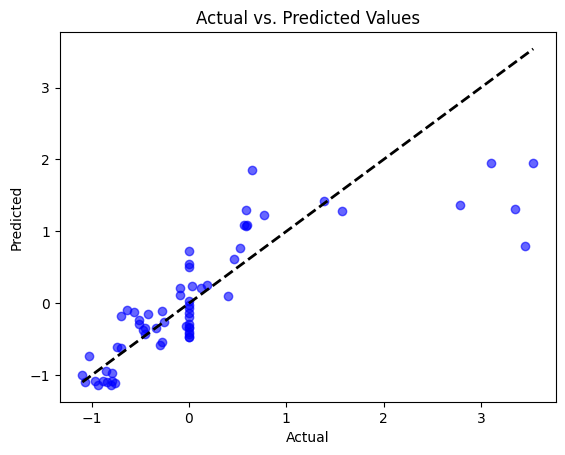

In [310]:
import matplotlib.pyplot as plt

# Actual vs Predicted plot
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)  # Plot actual vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Plot a diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')

plt.show()


In [314]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds, shuffle data before splitting
scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error',cv=kf)
print("Negative MSE scores:", scores)
print("Mean of scores:", scores.mean())
print("Standard deviation of scores:", scores.std())

Negative MSE scores: [-0.40021076 -0.21611356 -0.20774877 -0.28919478 -0.28128103]
Mean of scores: -0.2789097808383466
Standard deviation of scores: 0.06903996646875854
